In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

import seaborn as sns

In [24]:
%config InlineBackend.figure_format = 'retina'
# %load_ext watermark
az.style.use('arviz-darkgrid')
sns.set(style="ticks", context="talk")

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) 1 − Pr(vampire)$$

In [3]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

#### Code 3.2 - 3.5

We are goint to use the same function(s) we use on chapter 2 (code 2.3)

In [3]:
def get_prior(parameter_grid, prior_type="uniform"):
    
    dbl_exp = np.exp(- 5 * abs(parameter_grid - 0.5))
    trunc = (parameter_grid >= 0.5).astype(int)
    rev_trunc = (parameter_grid <= 0.5).astype(int)
    
    prior_dict = {"uniform": np.repeat(1/len(parameter_grid), 
                                       len(parameter_grid)),
                  "truncated": trunc / trunc.sum(),
                  "reverse truncated": rev_trunc / rev_trunc.sum(),
                  "double exponential": dbl_exp / dbl_exp.sum()
                  }
    
    return prior_dict[prior_type]

In [4]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9, prior_type="uniform"):
    """
    """
    # define grid.
    # Between 0 and 1, creates equally spaced samples for the parameter of interest.
    parameter_grid = np.linspace(0, 1, grid_points)

    prior = get_prior(parameter_grid, prior_type)
    
    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, parameter_grid)
    
    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return parameter_grid, posterior

In [109]:
param_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)

# Set the seed so we can replicate the sampling.
rng = np.random.default_rng(seed=9999)

samples = rng.choice(param_grid, p=posterior, size=int(1e5), replace=True)

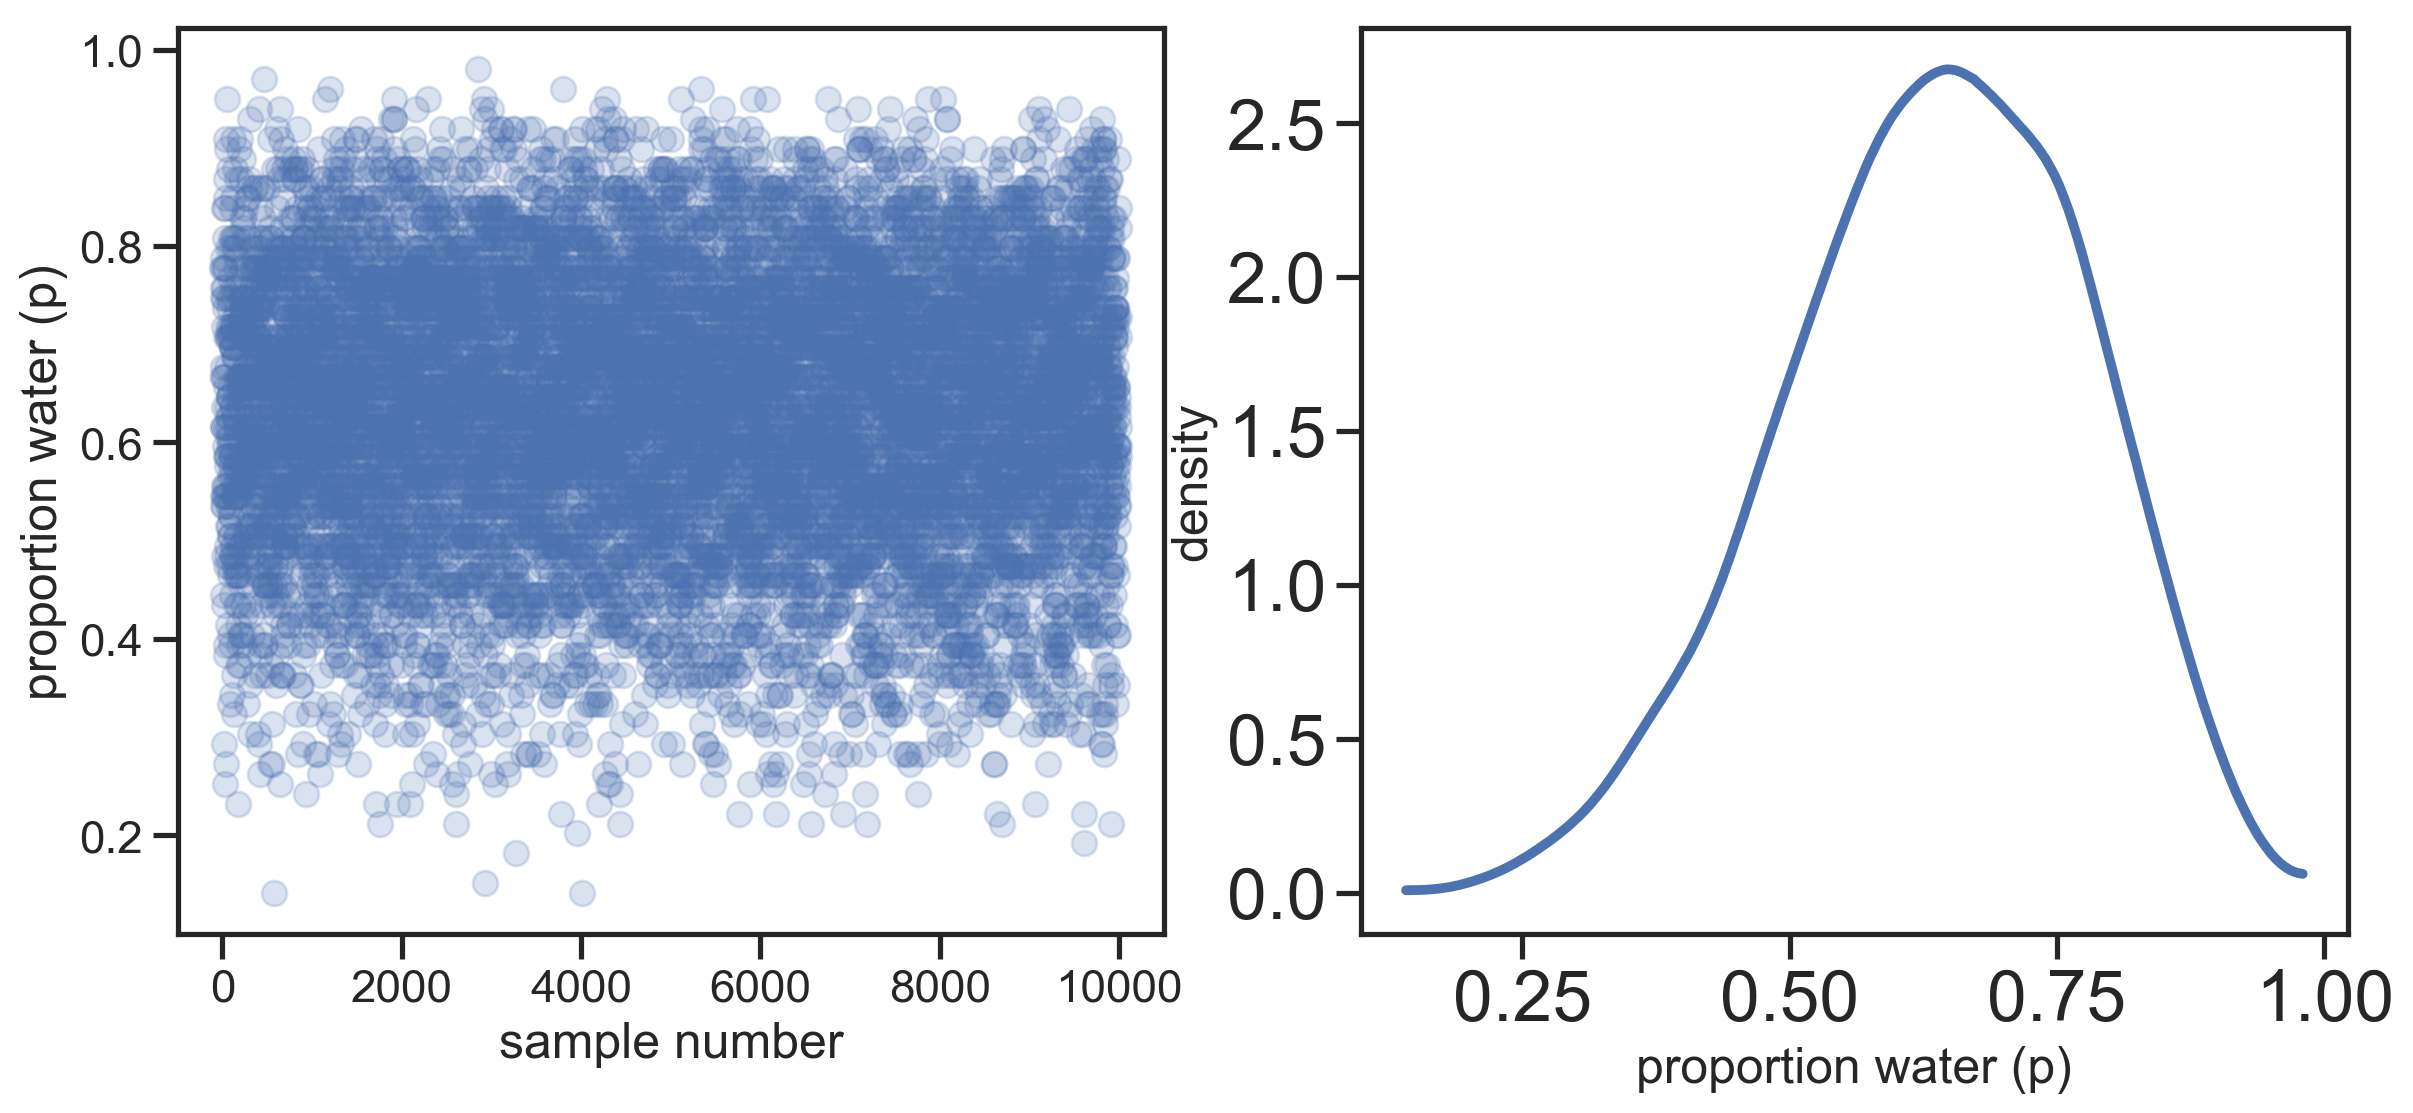

In [60]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")


az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

#### Code 3.6

In [62]:
sum(posterior[param_grid < 0.5]) # Actual posterior probability that p < 0.5

0.17183313110747478

#### Code 3.7

In [63]:
sum(samples < 0.5) / len(samples) # Empirical posterior probability that p < 0.5

0.1729

#### Code 3.8

In [64]:
sum((samples > 0.5) & (samples < 0.75)) / len(samples) # Empirical posterior probability that 0.5 < p < 0.75

0.6119

#### Code 3.9

In [66]:
# p at the 80th percentile.
# Therefore, anything below this p
# is in the lower 80th percentile 
# of the sample of the posterior distribution.

np.percentile(samples, 80) 

0.7575757575757577

#### Code 3.10

In [67]:
# The middle 80% interval,
# which lies between the 10th percentile and the 90th percentile.
np.percentile(samples, [10, 90]) 

array([0.44444444, 0.80808081])

#### Code 3.11

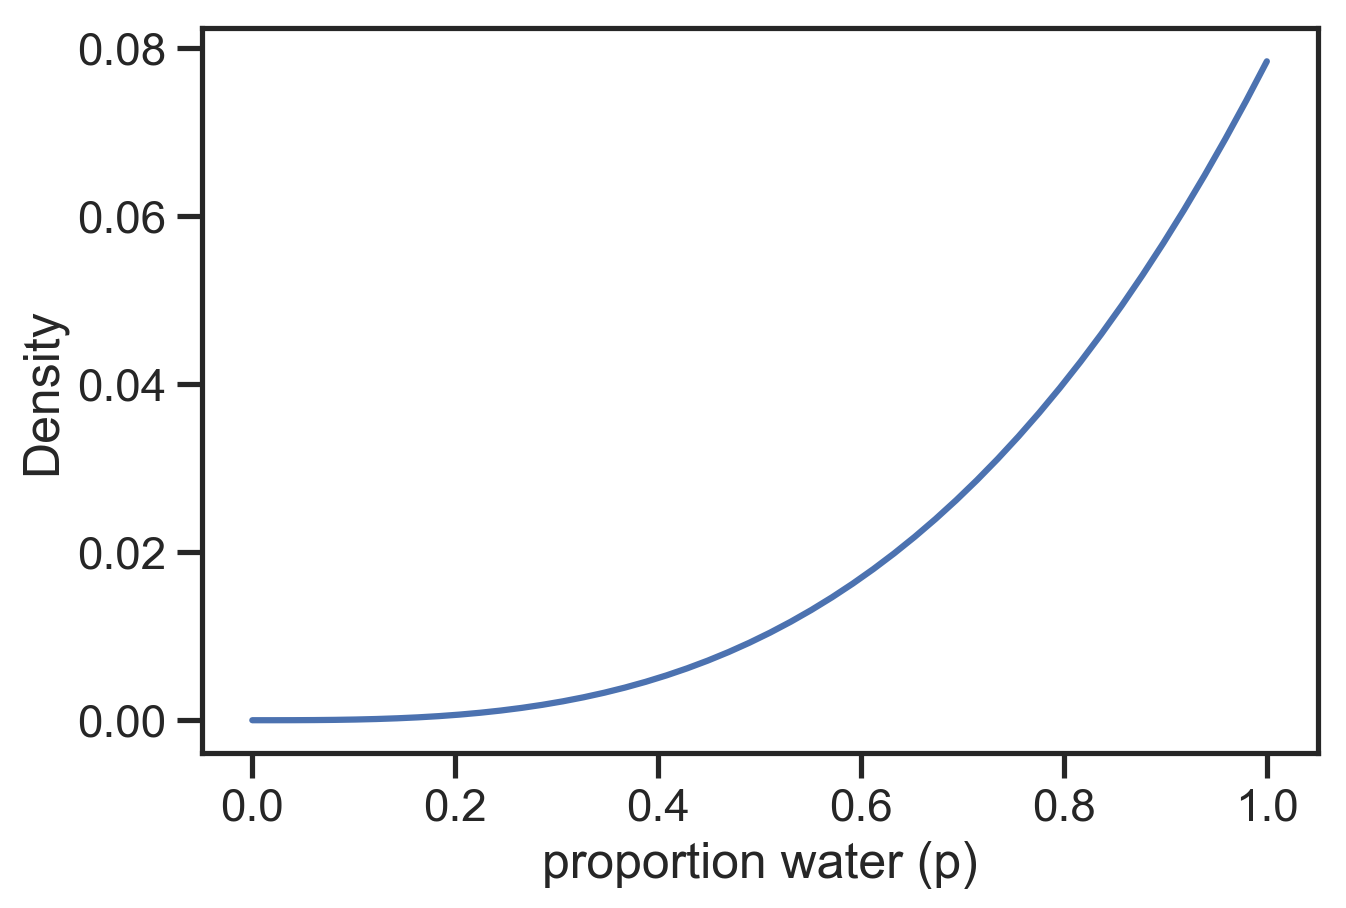

In [68]:
p_grid, posterior = posterior_grid_approx(grid_points=50, success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel("proportion water (p)")
plt.ylabel("Density");

#### Code 3.12

In [71]:
# Set the seed so we can replicate the sampling.
rng2 = np.random.default_rng(seed=11111)

# Draw samples of p from the posterior.
samples = rng2.choice(p_grid, p=posterior, size=int(1e4), replace=True)

# Identify the central 50%.
np.percentile(samples, [25, 75])

array([0.71428571, 0.93877551])

#### Code 3.13

In [72]:
az.hpd(samples, credible_interval=0.5)

array([0.81632653, 0.97959184])

#### Code 3.14

In [73]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [74]:
stats.mode(samples)[0]

array([1.])

#### Code 3.16

In [75]:
np.mean(samples), np.median(samples)

(0.8041938775510203, 0.836734693877551)

#### Code 3.17

Compute the weighted average loss for guessing _p_ = 0.5, where each loss is weighted by its corresponding posterior probability

In [76]:
sum(posterior * abs(0.5 - p_grid))

0.3200749687630154

In [84]:
sum(posterior * (0.5 - p_grid)**2)

0.12207996668054975

#### Code 3.18 and 3.19

Computing the weighted average loss for every possible guess of _p_.

The value of _p_ should match the median of the samples from the posterior.

In [87]:
abs_loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]

# Find the parameter corresponding to the smallest weighted average absolute loss.
p_grid[abs_loss == min(abs_loss)]

array([0.85714286])

In [88]:
quad_loss = [sum(posterior * (p - p_grid)**2) for p in p_grid]

# Find the parameter corresponding to the smallest weighted average quadratic loss.
p_grid[quad_loss == min(quad_loss)]

array([0.81632653])

#### Code 3.20

In [90]:
# Compute, given 2 tosses and probability of success = 0.7,
# the liklihood of observing each possible outcome
# (0 successes, 1 success, 2 successes).

stats.binom.pmf(k=range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [91]:
# Sample from the prior, as defined above.
# (ie. 2 tosses and probability of success = 0.7)

stats.binom.rvs(n=2, p=0.7, size=1) # Returns a sampled number of successes in 2 tosses.

array([1])

#### Code 3.22

In [93]:
# Get 10 samples from the prior.

stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 1, 2, 1])

#### Code 3.23

In [94]:
# Sample 10000 times from the prior.
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))

# Compute the likelihood of each observation.
[(dummy_w == i).mean() for i in range(3)]

[0.08926, 0.41805, 0.49269]

#### Code 3.24, and 3.25

Text(0.5, 1.0, 'p = 0.6; 9 tosses')

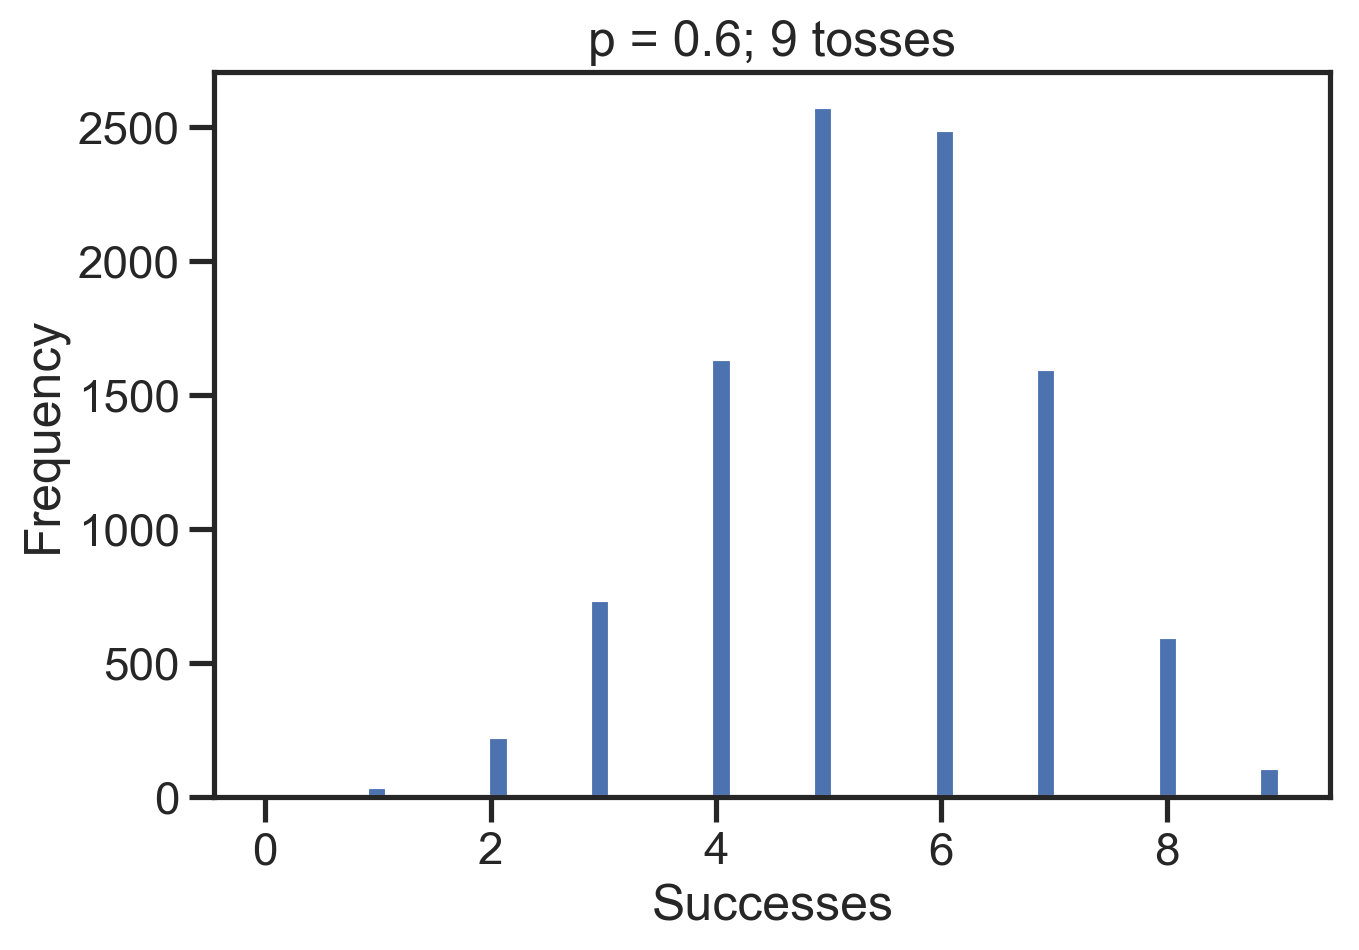

In [106]:
# Sample 10000 times, but with 10 tosses.
P = 0.6
TOSSES = 9

dummy_w = stats.binom.rvs(n=TOSSES, p=P, size=int(1e4))
# dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
# dummy_w = stats.binom.rvs(n=9, p=samples)

plt.hist(dummy_w, 
         bins=50,
#          bins=range(0, 10)
        )
plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"p = {P}; {TOSSES} tosses")

#### Code 3.26

Text(0.5, 1.0, 'Posterior distribtion; 9 tosses')

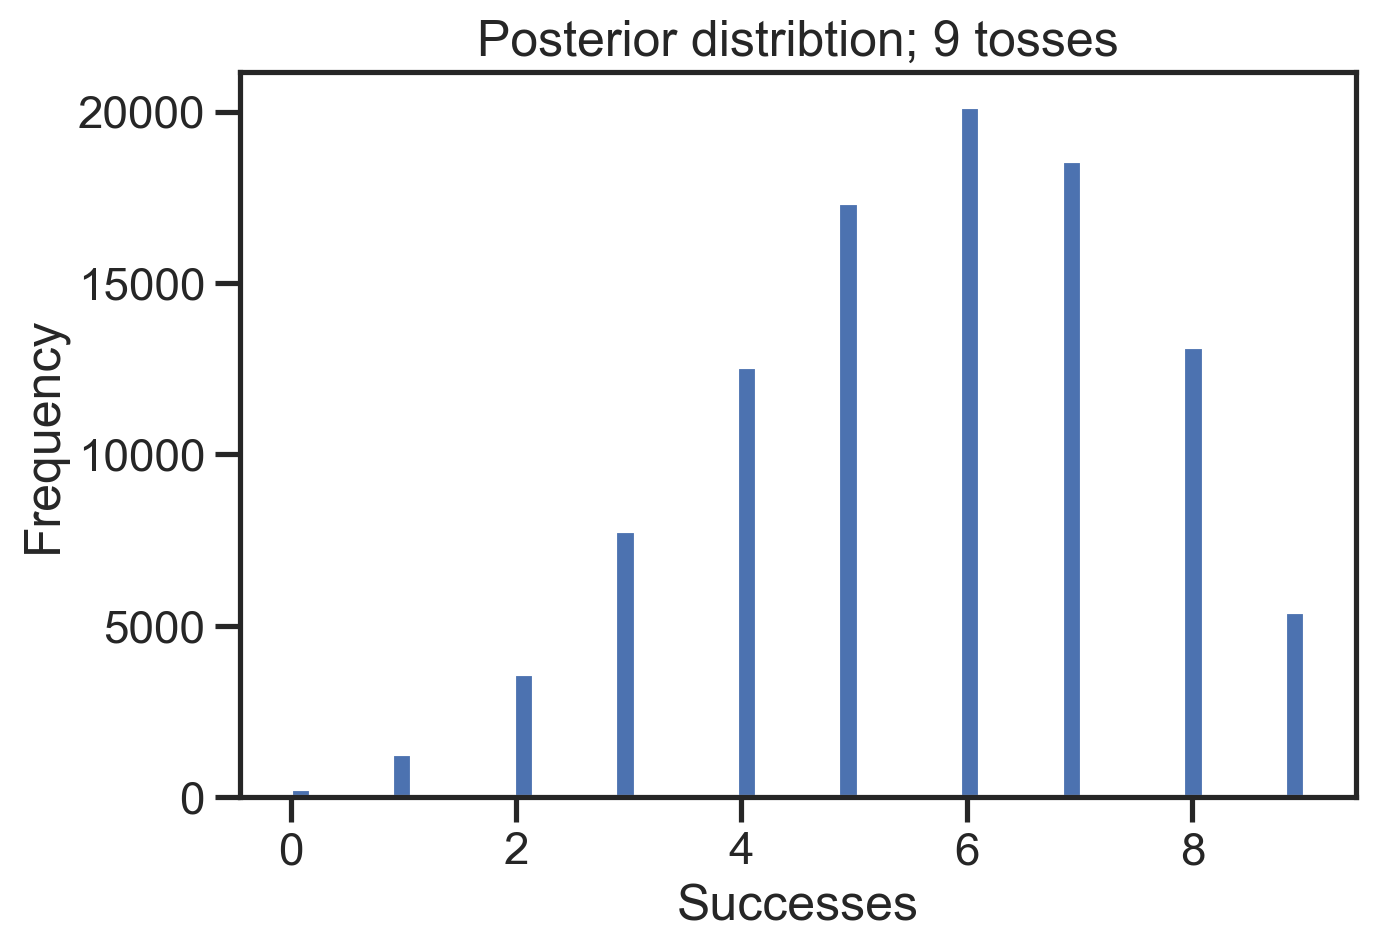

In [111]:
# Calculate the sampled distributions for each parameter value in 'samples'.
# the kwarg `p` can be a vector or a single value.
dummy_w = stats.binom.rvs(n=9, p=samples)

plt.hist(dummy_w, 
         bins=50,
#          bins=range(0, 10)
        )
plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"Posterior distribtion; {TOSSES} tosses")

#### Code 3.27

**EASY**

In [5]:
# This cell sets up the posterior required for the 3E questions.
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)

np.random.seed(100)

samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

(array([   9.,   68.,  278.,  804., 1339., 2172., 2447., 1714., 1008.,
         161.]),
 array([0.11111111, 0.1979798 , 0.28484848, 0.37171717, 0.45858586,
        0.54545455, 0.63232323, 0.71919192, 0.80606061, 0.89292929,
        0.97979798]),
 <a list of 10 Patch objects>)

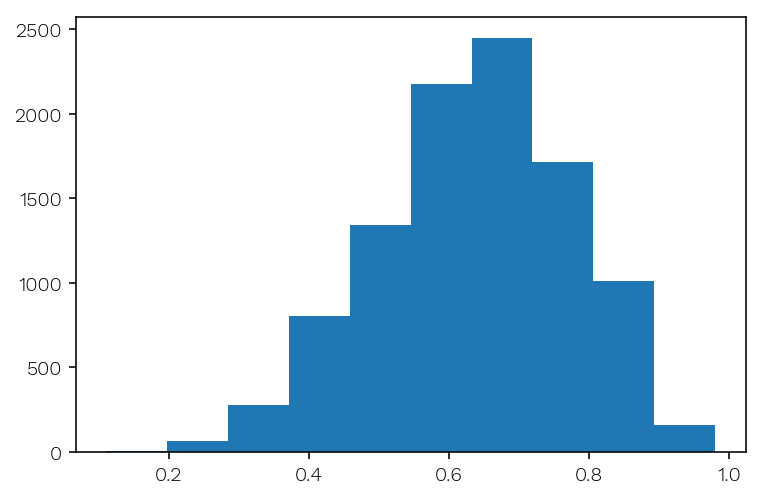

In [7]:
plt.hist(samples)

In [11]:
# 3E1. How much posterior probability lies below p = 0.2?

sum(samples < 0.2) / len(samples)

0.0009

In [13]:
# 3E2. How much posterior probability lies above p = 0.8?

sum(samples > 0.8) / len(samples)

0.1169

In [15]:
# 3E3. How much posterior probability lies between p = 0.2 and p = 0.8?

sum((samples > 0.2) & (samples < 0.8)) / len(samples)

0.8822

In [16]:
# 3E4. 20% of the posterior probability lies below which value of p?

np.percentile(samples, 20)

0.5151515151515152

In [17]:
# 3E5. 20% of the posterior probability lies above which value of p?

np.percentile(samples, 80)

0.7575757575757577

In [18]:
# 3E6. Which values of p contain the narrowest interval equal to 66% of the posterior probability?

az.hpd(samples, 0.66)

array([0.50505051, 0.77777778])

In [22]:
# 3E7. Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

print( np.percentile(samples, 17), np.percentile(samples, 83) )

0.494949494949495 0.7777777777777777


**MEDIUM**

Text(0.5, 1.0, '8 successes\n15 tosses')

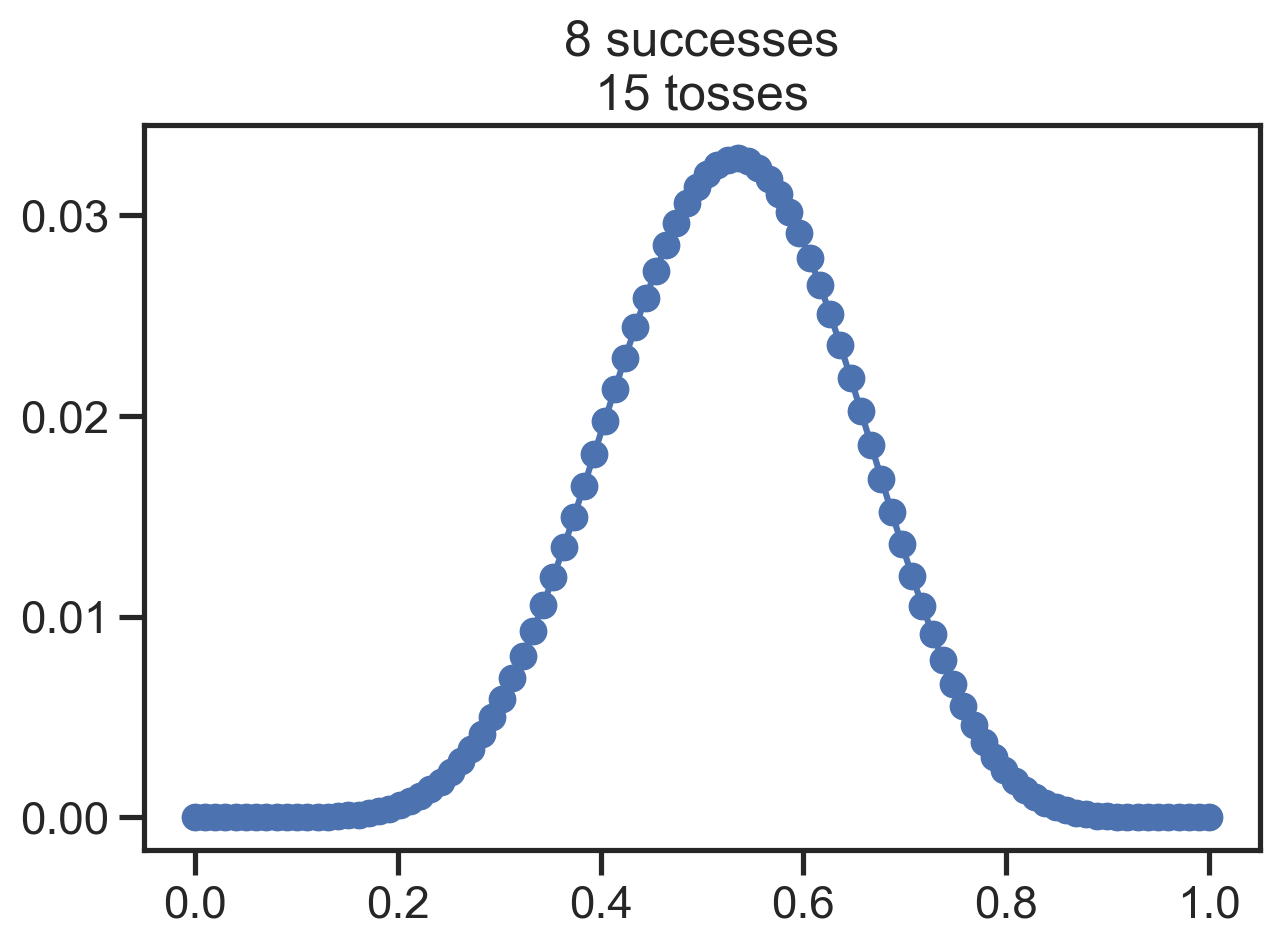

In [46]:
# 3M1. 
# Suppose the globe tossing data had turned out to be 8 water in 15 tosses.
# Construct the posterior distribution, using grid approximation. Use the same flat prior as before.

p_grid, posterior = posterior_grid_approx(grid_points=100, success=8, tosses=15)

plt.plot(p_grid, posterior, "o-")
plt.gca().set_title("8 successes\n15 tosses")

In [47]:
p_grid[posterior == max(posterior)]

array([0.53535354])

In [36]:
# 3M2. 
# Draw 10,000 samples from the grid approximation from above. 
# Then use the samples to calculate the 90% HPDI for p.

samps = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

az.hpd(samps, 0.90)

array([0.34343434, 0.72727273])

Text(0.5, 1.0, 'Posterior distribution; 15 tosses')

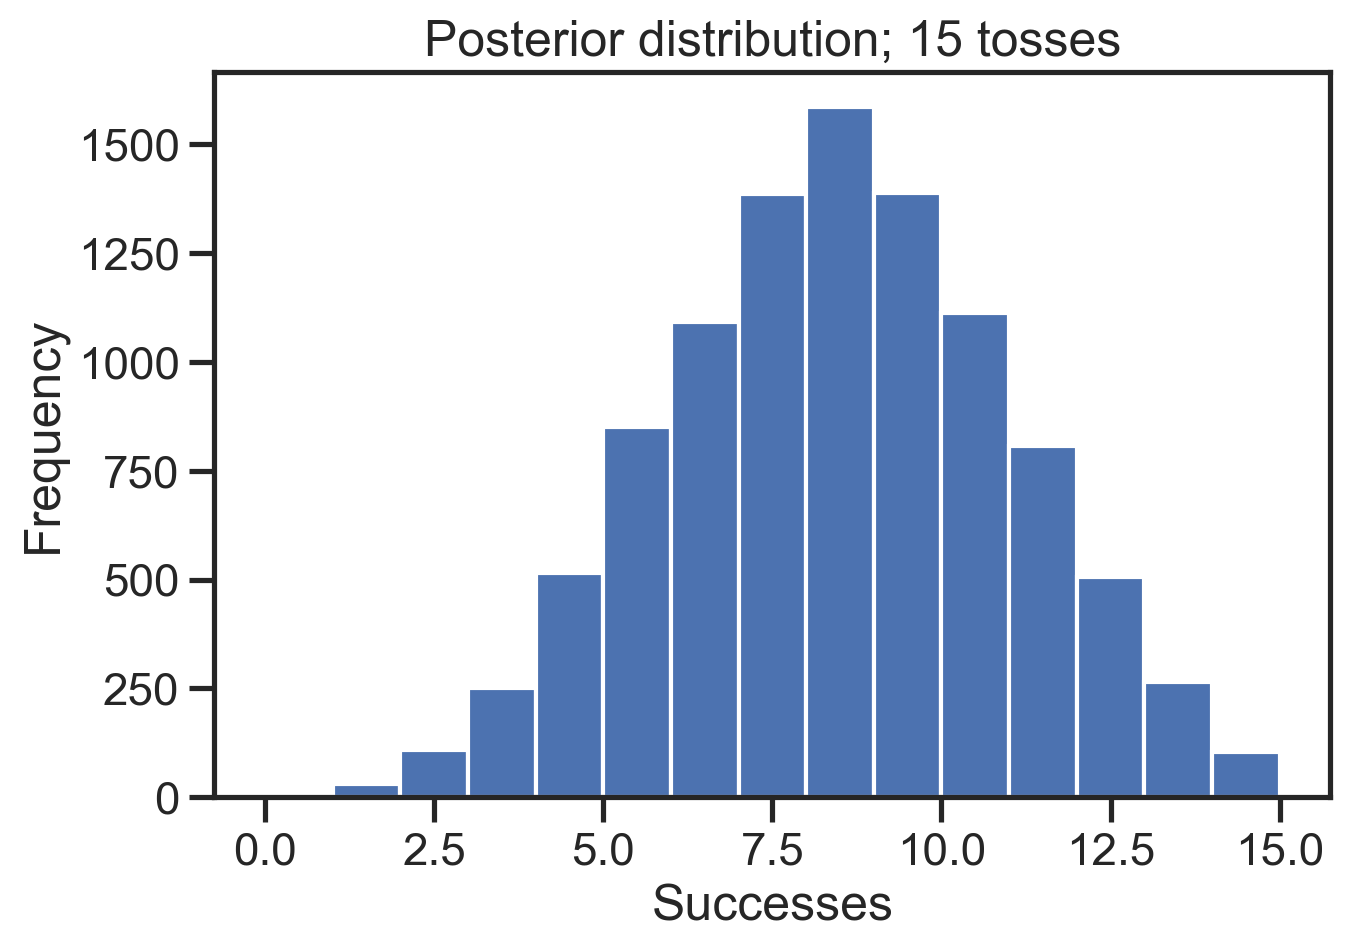

In [48]:
# 3M3. 
# Construct a posterior predictive check for this model and data. 
# This means simulate the distribution of samples, averaging over the posterior uncertainty in p. 
# What is the probability of observing 8 water in 15 tosses?


# Calculate the sampled distributions for each parameter value in 'samples'.
# the kwarg `p` can be a vector or a single value.
dummy1 = stats.binom.rvs(n=15, p=samps)

plt.hist(dummy1, 
         bins=15)

plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"Posterior distribution; 15 tosses")


In [49]:
sum(dummy1 == 8) / len(dummy1)

0.1586

Text(0.5, 1.0, 'Posterior distribution; 9 tosses')

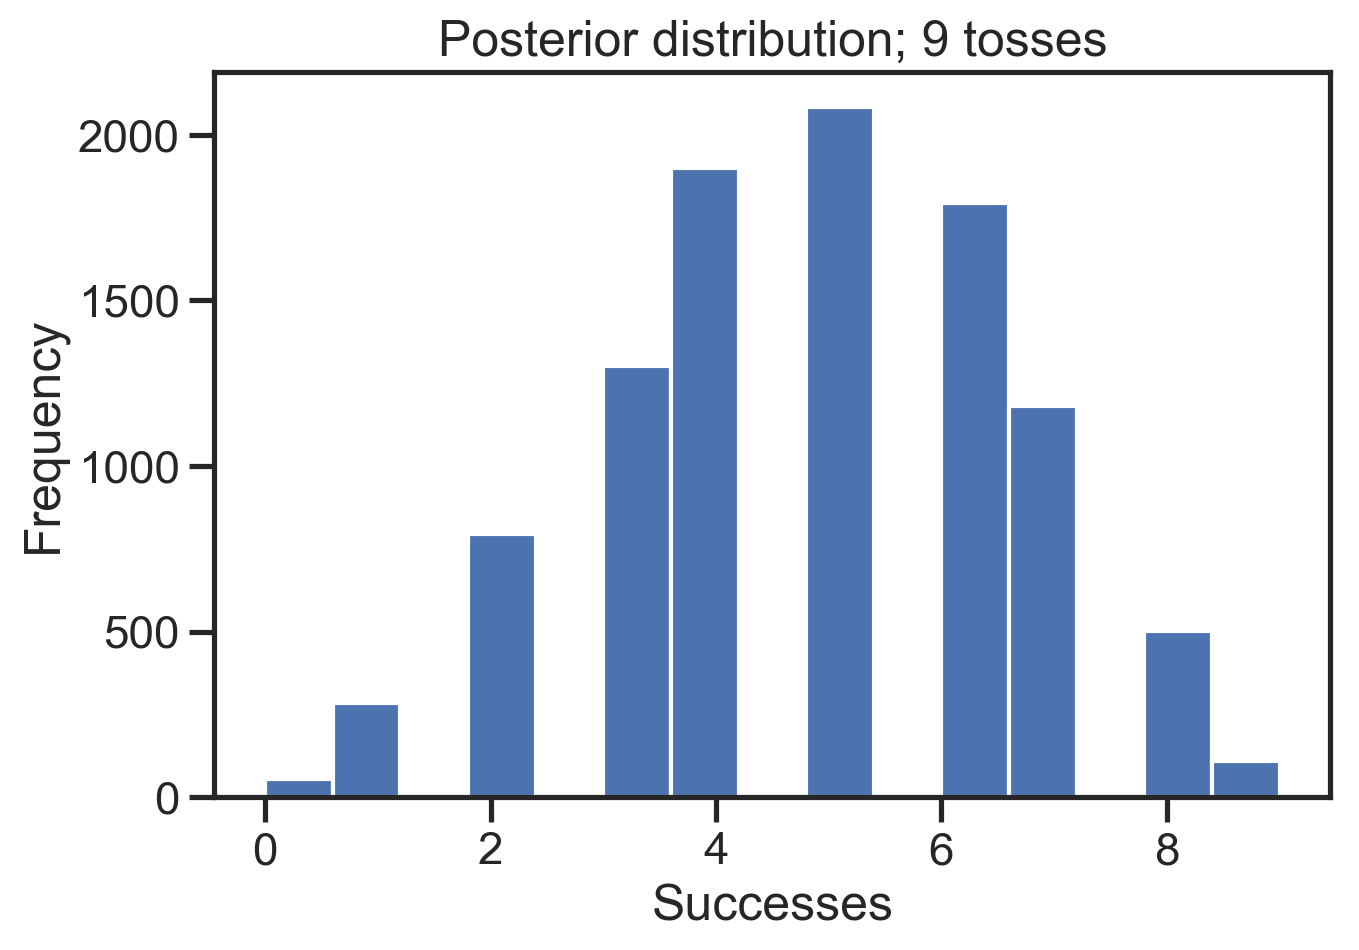

In [50]:
# 3M4. 
# Using the posterior distribution constructed from the new (8/15) data, 
# now calculate the probability of observing 6 water in 9 tosses.


# Calculate the sampled distributions for each parameter value in 'samples'.
# the kwarg `p` can be a vector or a single value.
dummy2 = stats.binom.rvs(n=9, p=samps)

plt.hist(dummy2, 
         bins=15)

plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"Posterior distribution; 9 tosses")

In [51]:
sum(dummy2 == 6) / len(dummy2)

0.1793

Text(0.5, 1.0, '8 successes\n15 tosses')

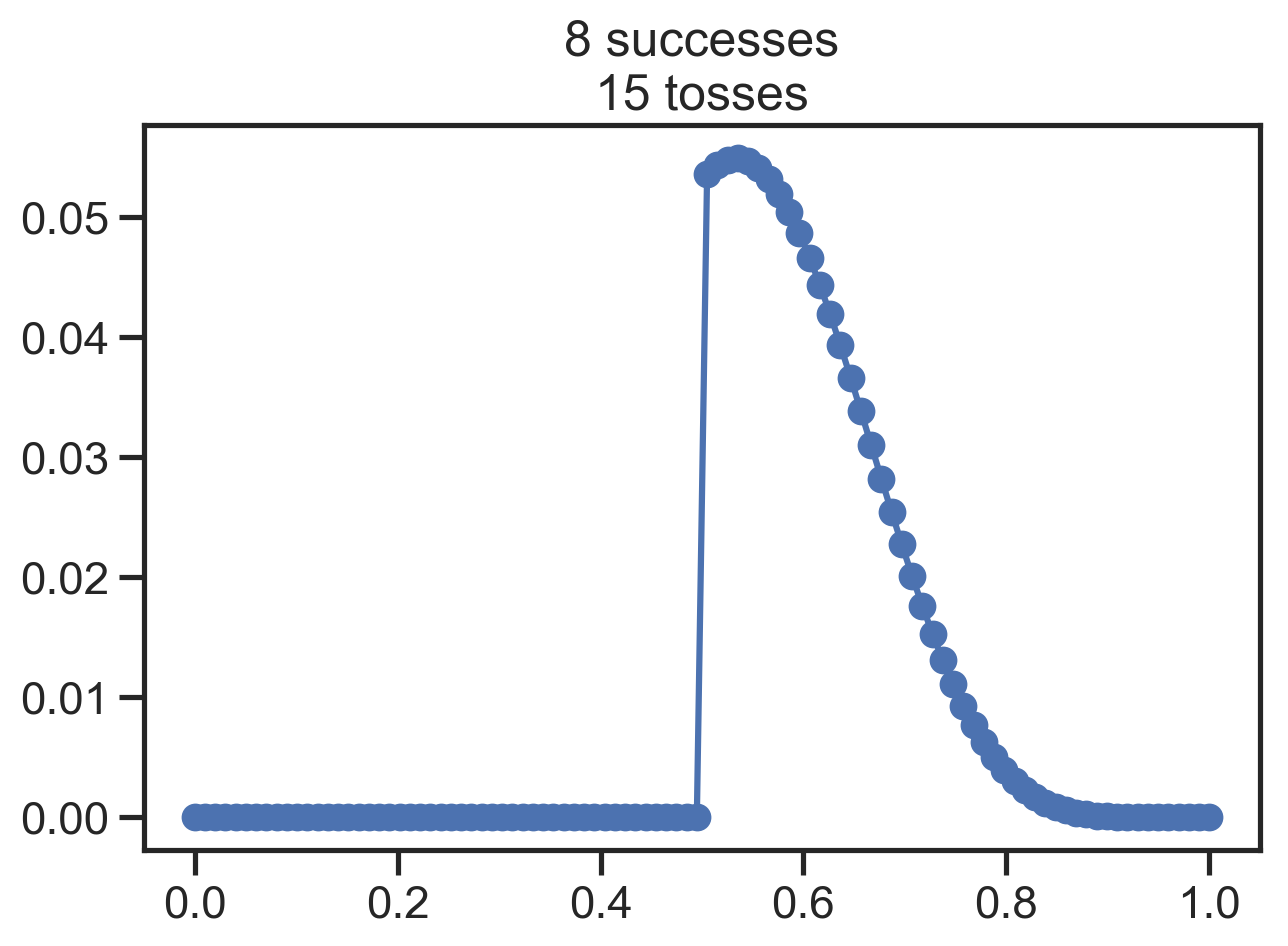

In [53]:
# 3M5. 
# Start over at 3M1, but now use a prior that is zero below p=0.5 and a constant above p=0.5.
# This corresponds to prior information that a majority of the Earth’s surface is water. 
# Repeat each problem above and compare the inferences. 
# What difference does the better prior make? 
# If it helps, compare inferences (using both priors) to the true value p = 0.7.


# M1
p_grid, posterior_trunc = posterior_grid_approx(grid_points=100, success=8, tosses=15, prior_type="truncated")

plt.plot(p_grid, posterior, "o-")
plt.gca().set_title("8 successes\n15 tosses")

In [55]:
# M2. 
# Draw 10,000 samples from the grid approximation from above. 
# Then use the samples to calculate the 90% HPDI for p.

samps_trunc  = np.random.choice(p_grid, p=posterior_trunc, size=int(1e4), replace=True)

az.hpd(samps, 0.90)

array([0.50505051, 0.70707071])

Text(0.5, 1.0, 'Posterior distribution; 15 tosses')

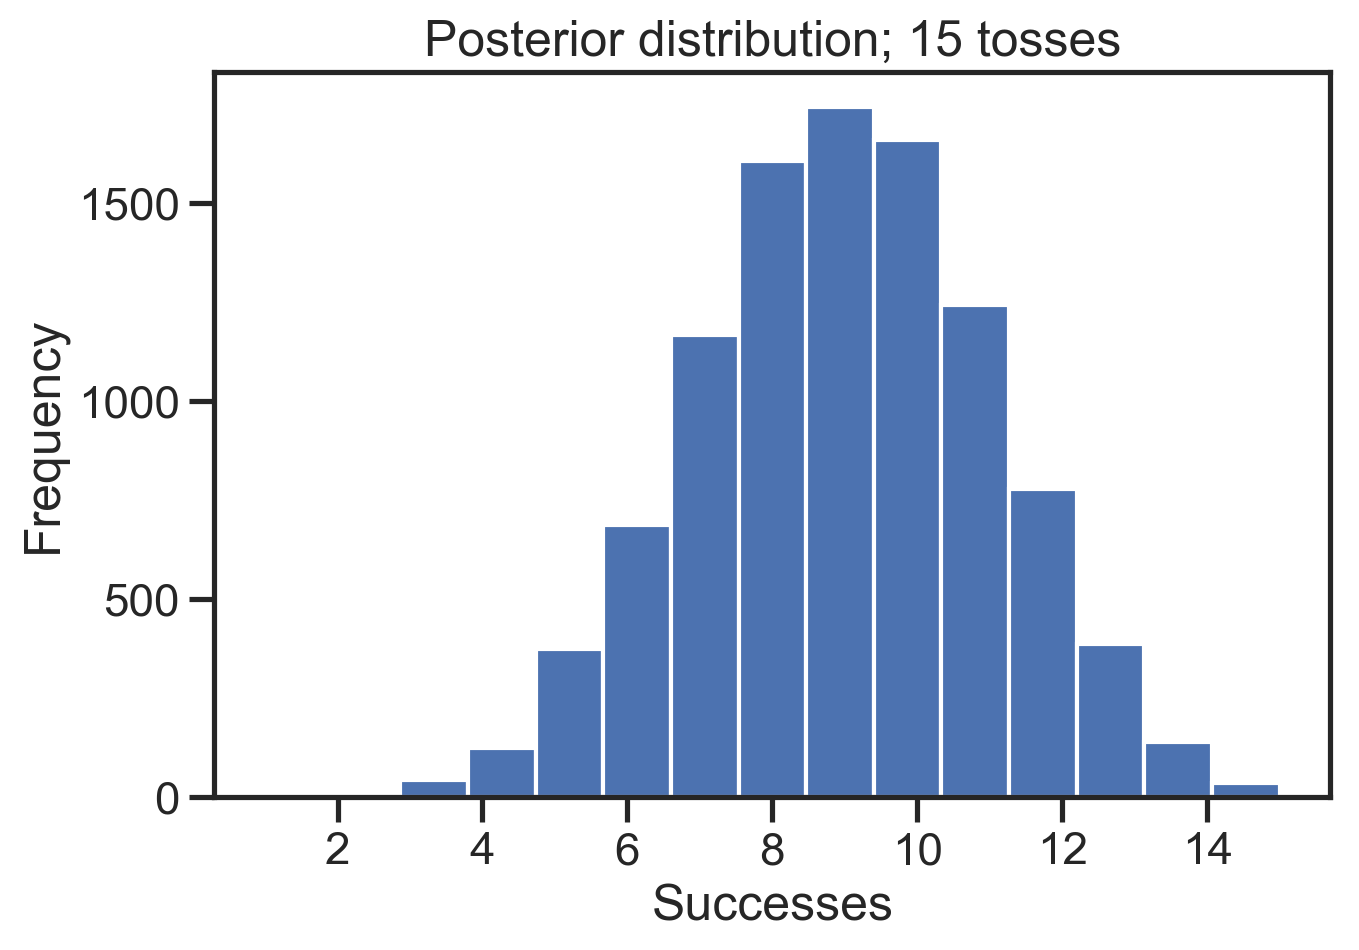

In [57]:
# M3. 
# Construct a posterior predictive check for this model and data. 
# This means simulate the distribution of samples, averaging over the posterior uncertainty in p. 
# What is the probability of observing 8 water in 15 tosses?


# Calculate the sampled distributions for each parameter value in 'samples'.
# the kwarg `p` can be a vector or a single value.
dummy_trunc1 = stats.binom.rvs(n=15, p=samps_trunc)

plt.hist(dummy_trunc1, 
         bins=15)

plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"Posterior distribution; 15 tosses")


In [58]:
sum(dummy_trunc1 == 8) / len(dummy_trunc1)

0.1607

Text(0.5, 1.0, 'Posterior distribution; 9 tosses')

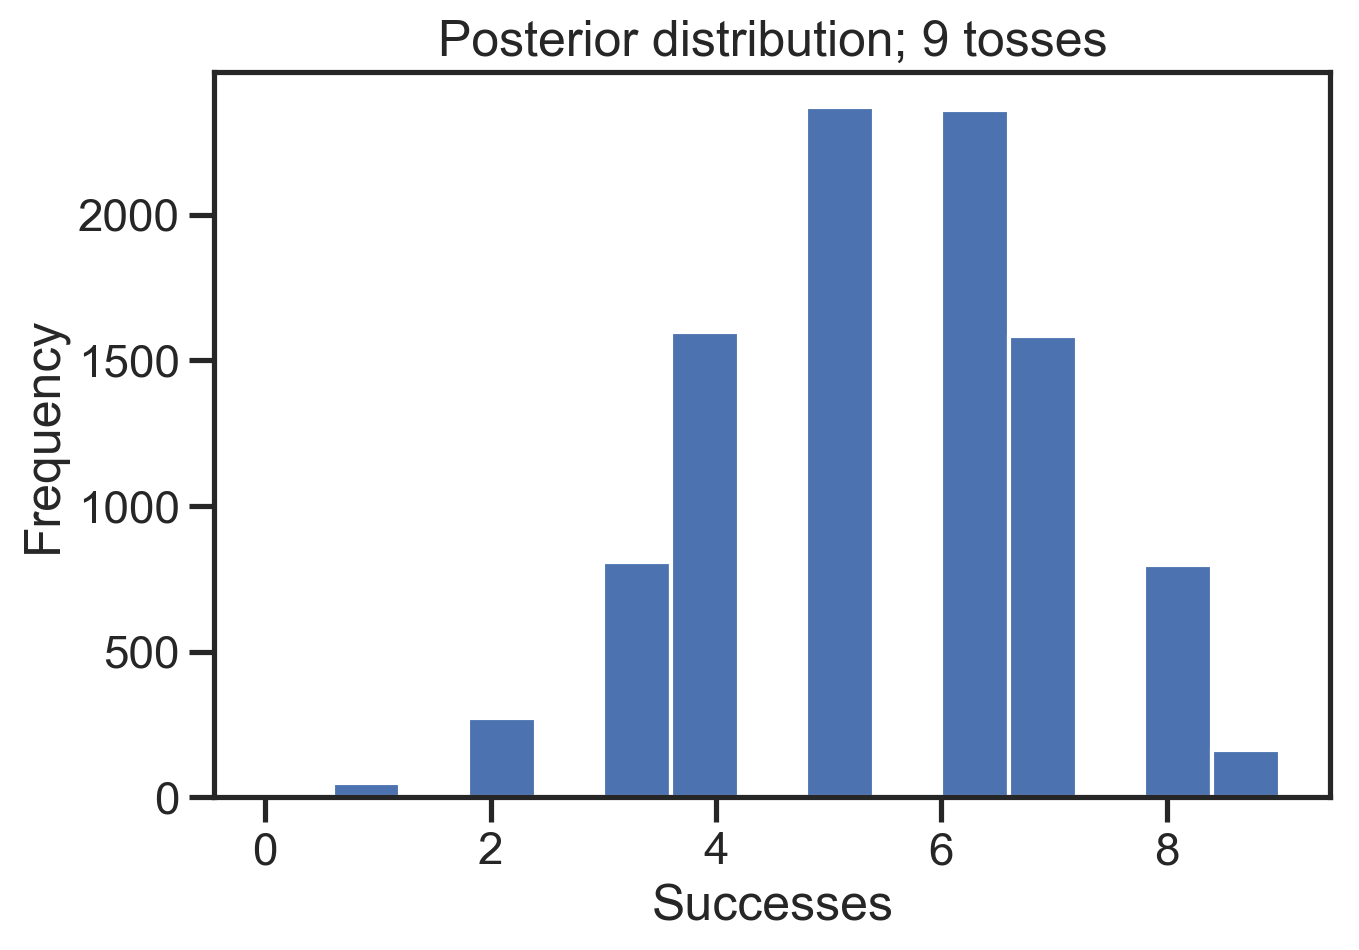

In [59]:
# M4. 
# Using the posterior distribution constructed from the new (8/15) data, 
# now calculate the probability of observing 6 water in 9 tosses.


# Calculate the sampled distributions for each parameter value in 'samples'.
# the kwarg `p` can be a vector or a single value.
dummy_trunc2 = stats.binom.rvs(n=9, p=samps_trunc)

plt.hist(dummy_trunc2, 
         bins=15)

plt.xlabel("Successes")
plt.ylabel("Frequency")
plt.title(f"Posterior distribution; 9 tosses")

In [60]:
sum(dummy_trunc2 == 6) / len(dummy_trunc2)

0.2358

In [75]:
# 3M6. 
# Suppose you want to estimate the Earth’s proportion of water very precisely. 
# Specifically, you want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. 
# This means the distance between the upper and lower bound of the interval should be 0.05. 
# How many times will you have to toss the globe to do this?

P = 8/15
TOSSES = 2000

p_grid, posterior = posterior_grid_approx(grid_points=100, success=int(P * TOSSES), tosses=TOSSES)

samps = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

interval = az.hpd(samps, 0.99)

interval[1] - interval[0]

0.0505050505050505

#### Code 3.28

In [26]:
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

#### Code 3.30

In [27]:
sum(birth1) + sum(birth2)

111

In [28]:
%watermark -n -u -v -iv -w

numpy    1.17.4
autopep8 1.4.4
pymc3    3.8
arviz    0.6.1
json     2.0.9
last updated: Mon Jan 13 2020 

CPython 3.7.3
IPython 7.11.1
watermark 2.0.2
